# Image Processing

This notebook shows some exemplary image processing algorithms. Note that plotting methods should always be called after preprocessing modules. `ds.pp.threshold(0.99).pl.colorize('red').pl.show()` will work, whereas `ds.pl.colorize('red').pp.threshold(0.99).pl.show()` will not show the thresholded image correctly.

In [1]:
%reload_ext autoreload
%autoreload 2

import spatialproteomics
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# loading in a data set and performing some formatting for convenience
ds = xr.open_zarr("../../data/BNHL_166_4_I2_LK.zarr")
ds["_properties"] = ds["_labels"]
ds = ds.pp.drop_layers("_labels")
# focusing on just one channel to illustrate the concepts better
ds_single_channel = ds.pp["IKZF3"]
ds_multichannel = ds.pp[["PAX5", "CD3"]]
ds

<xarray.Dataset>
Dimensions:        (cells: 12560, channels: 56, y: 3000, x: 3000, features: 4,
                    labels: 8, props: 2)
Coordinates:
  * cells          (cells) int64 1 2 3 4 5 6 ... 12556 12557 12558 12559 12560
  * channels       (channels) <U11 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * features       (features) <U10 'centroid-0' 'centroid-1' ... '_original_'
  * labels         (labels) int64 1 2 3 4 5 6 7 8
  * props          (props) <U6 '_color' '_name'
  * x              (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * y              (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
Data variables:
    _arcsinh_mean  (cells, channels) float64 dask.array<chunksize=(3140, 14), meta=np.ndarray>
    _arcsinh_sum   (cells, channels) float64 dask.array<chunksize=(3140, 14), meta=np.ndarray>
    _image         (channels, y, x) uint8 dask.array<chunksize=(7, 375, 750), meta=np.ndarray>
    _obs           (cells, features) float64 dask.array<chunksize=(12560, 2), meta=np.ndarray>
    _raw_mean      (cells, channels) float64 dask.array<chunksize=(3140, 14), meta=np.ndarray>
    _raw_sum       (cells, channels) float64 dask.array<chunksize=(3140, 14), meta=np.ndarray>
    _segmentation  (y, x) int64 dask.array<chunksize=(375, 375), meta=np.ndarray>
    _properties    (labels, props) object dask.array<chunksize=(8, 2), meta=np.ndarray>

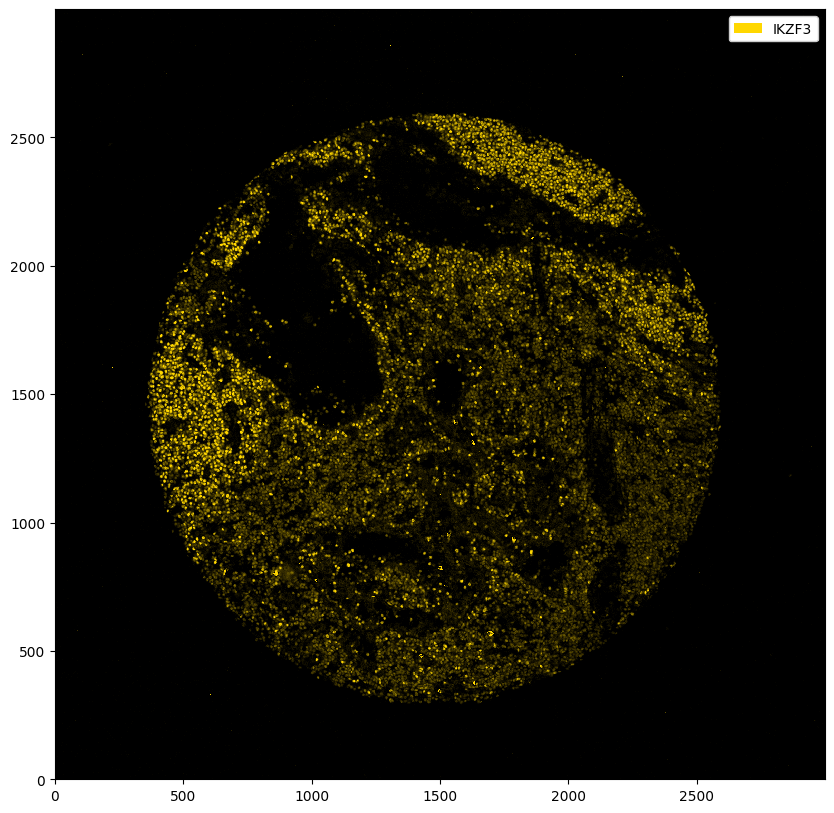

In [3]:
plt.figure(figsize=(10, 10))
_ = ds_single_channel.pl.colorize("gold").pl.show()

The marker above seems to have worked fairly well, but you can observe some unspecific binding. To boost the signal-to-noise ratio, we can threshold the image. This basically means that every value below that threshold gets set to zero. In addition, the other intensities get shifted downwards by your specified value (you can deactivate this behavior by setting `pp.threshold(shift=False)`, which will only set values below the threshold to 0 and keep the other values unchanged). You can either threshold using an absolute intensity, or using a quantile value.

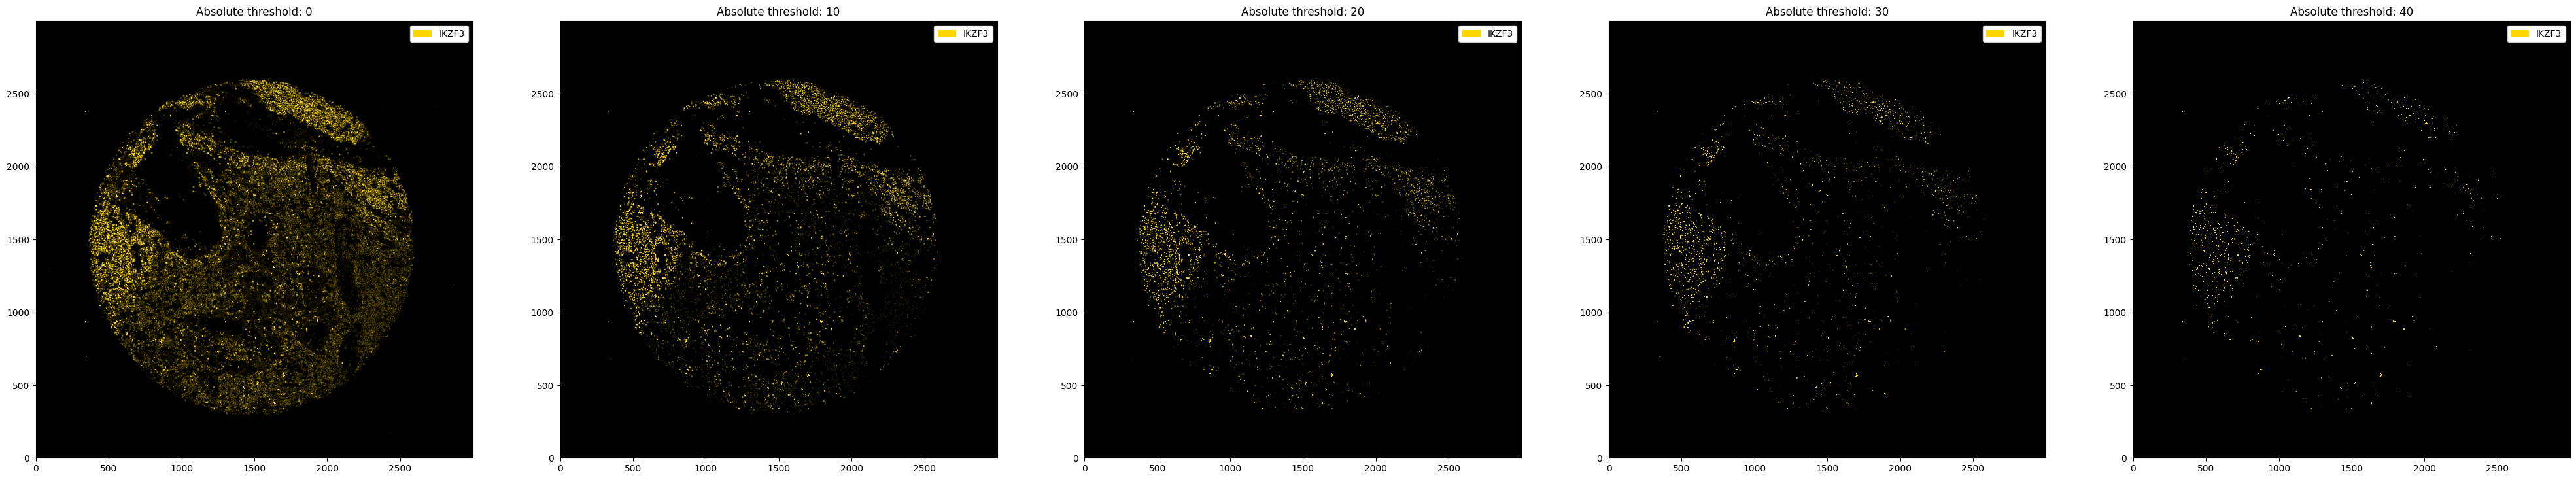

In [4]:
# thresholding with absolute intensity
fig, ax = plt.subplots(1, 5, figsize=(50, 10))

for i in range(5):
    _ = ds_single_channel.pp.threshold(intensity=10 * i).pl.colorize("gold").pl.show(ax=ax[i])
    ax[i].set_title(f"Absolute threshold: {10 * i}")

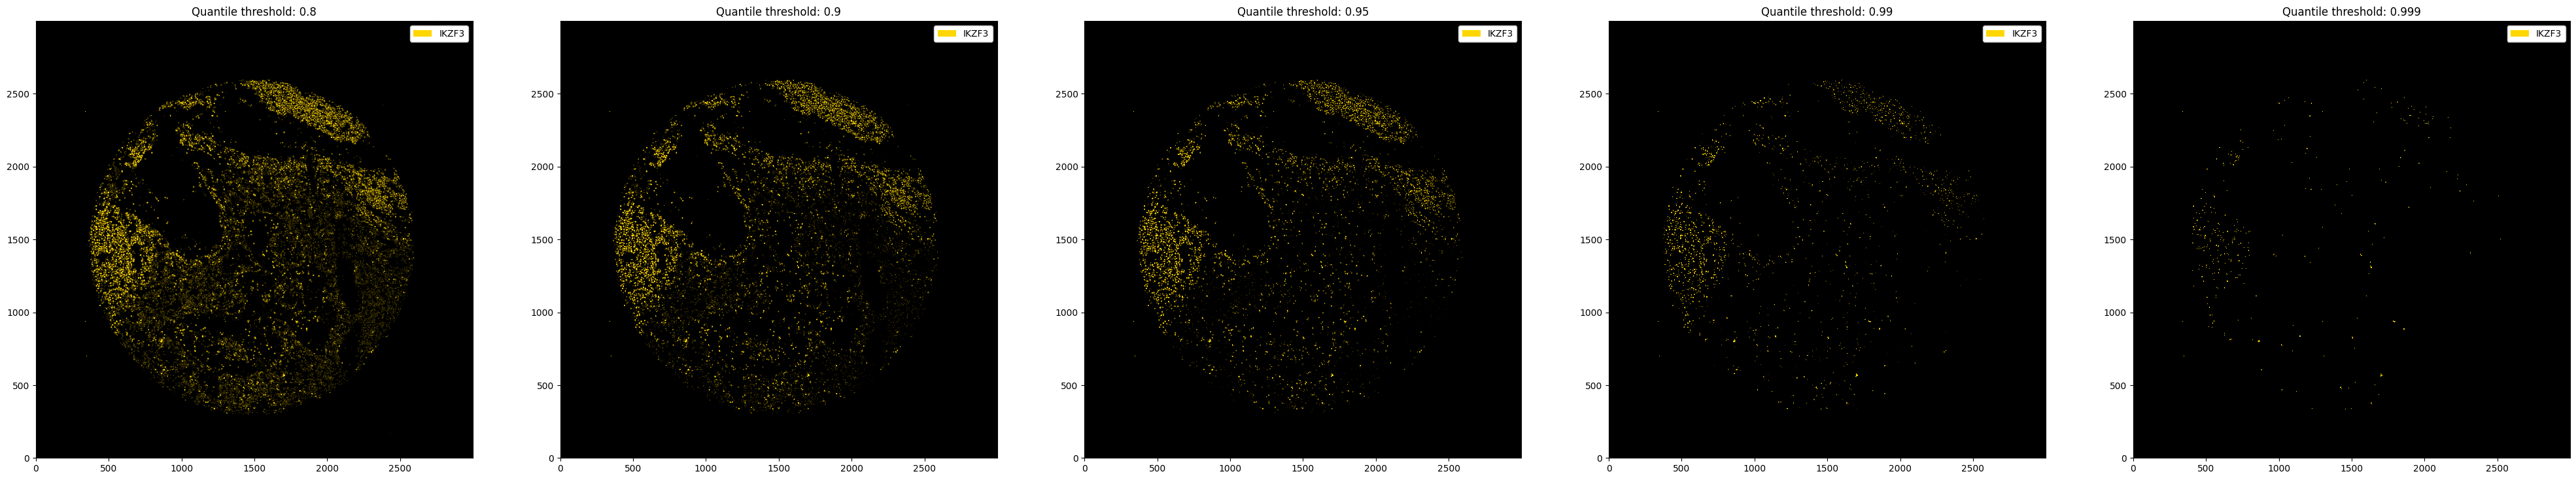

In [5]:
# thresholding with quantiles
fig, ax = plt.subplots(1, 5, figsize=(50, 10))

for i, quantile in enumerate([0.8, 0.9, 0.95, 0.99, 0.999]):
    _ = ds_single_channel.pp.threshold(quantile=quantile).pl.colorize("gold").pl.show(ax=ax[i])
    ax[i].set_title(f"Quantile threshold: {quantile}")

You can also use different thresholds for different channels.

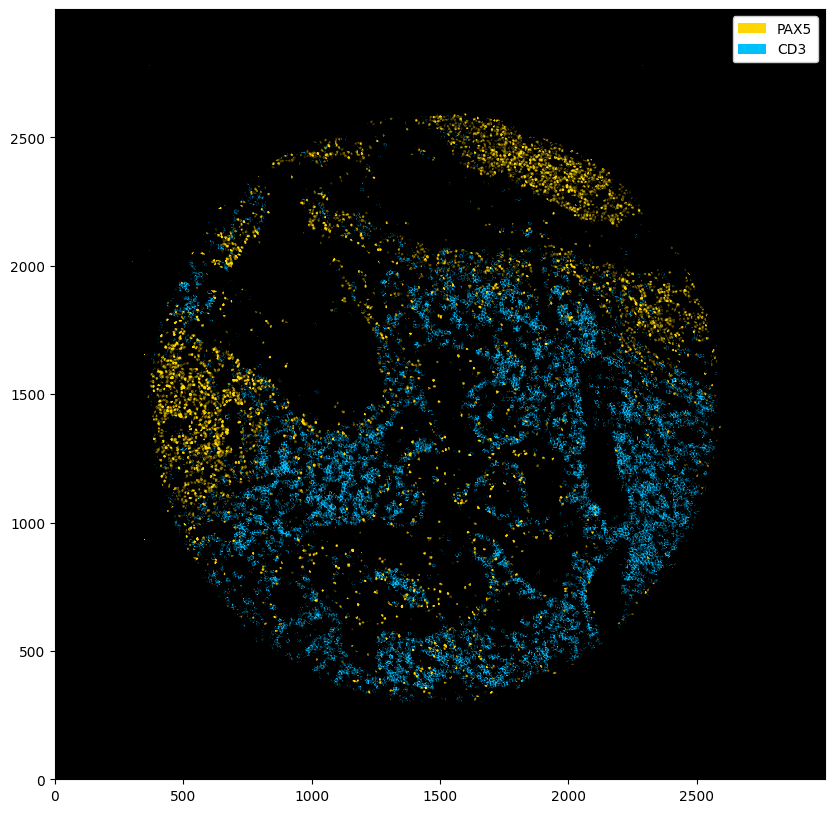

In [6]:
fig = plt.figure(figsize=(10, 10))
_ = ds_multichannel.pp.threshold(quantile=[0.95, 0.9]).pl.colorize(["gold", "deepskyblue"]).pl.show()

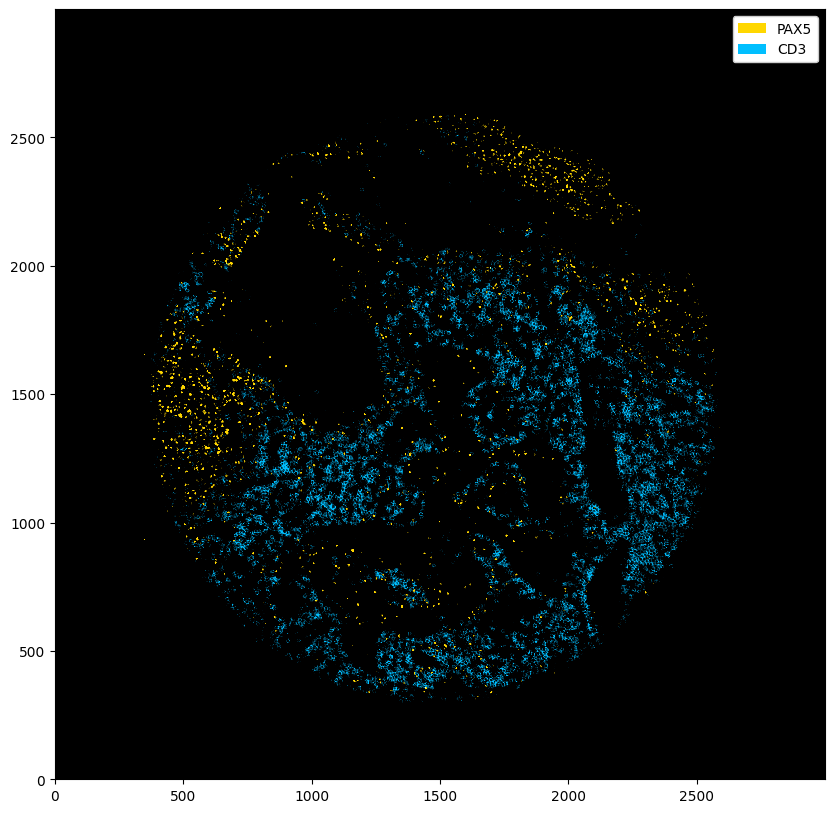

In [7]:
fig = plt.figure(figsize=(10, 10))
_ = ds_multichannel.pp.threshold(intensity=[20, 30]).pl.colorize(["gold", "deepskyblue"]).pl.show()

After thresholding, a medianfilter can be useful to reduce the noise further. We can use the `pp.apply()` method to apply any preprocessing function of our choice.

Text(0.5, 1.0, 'Thresholded and median filtered')

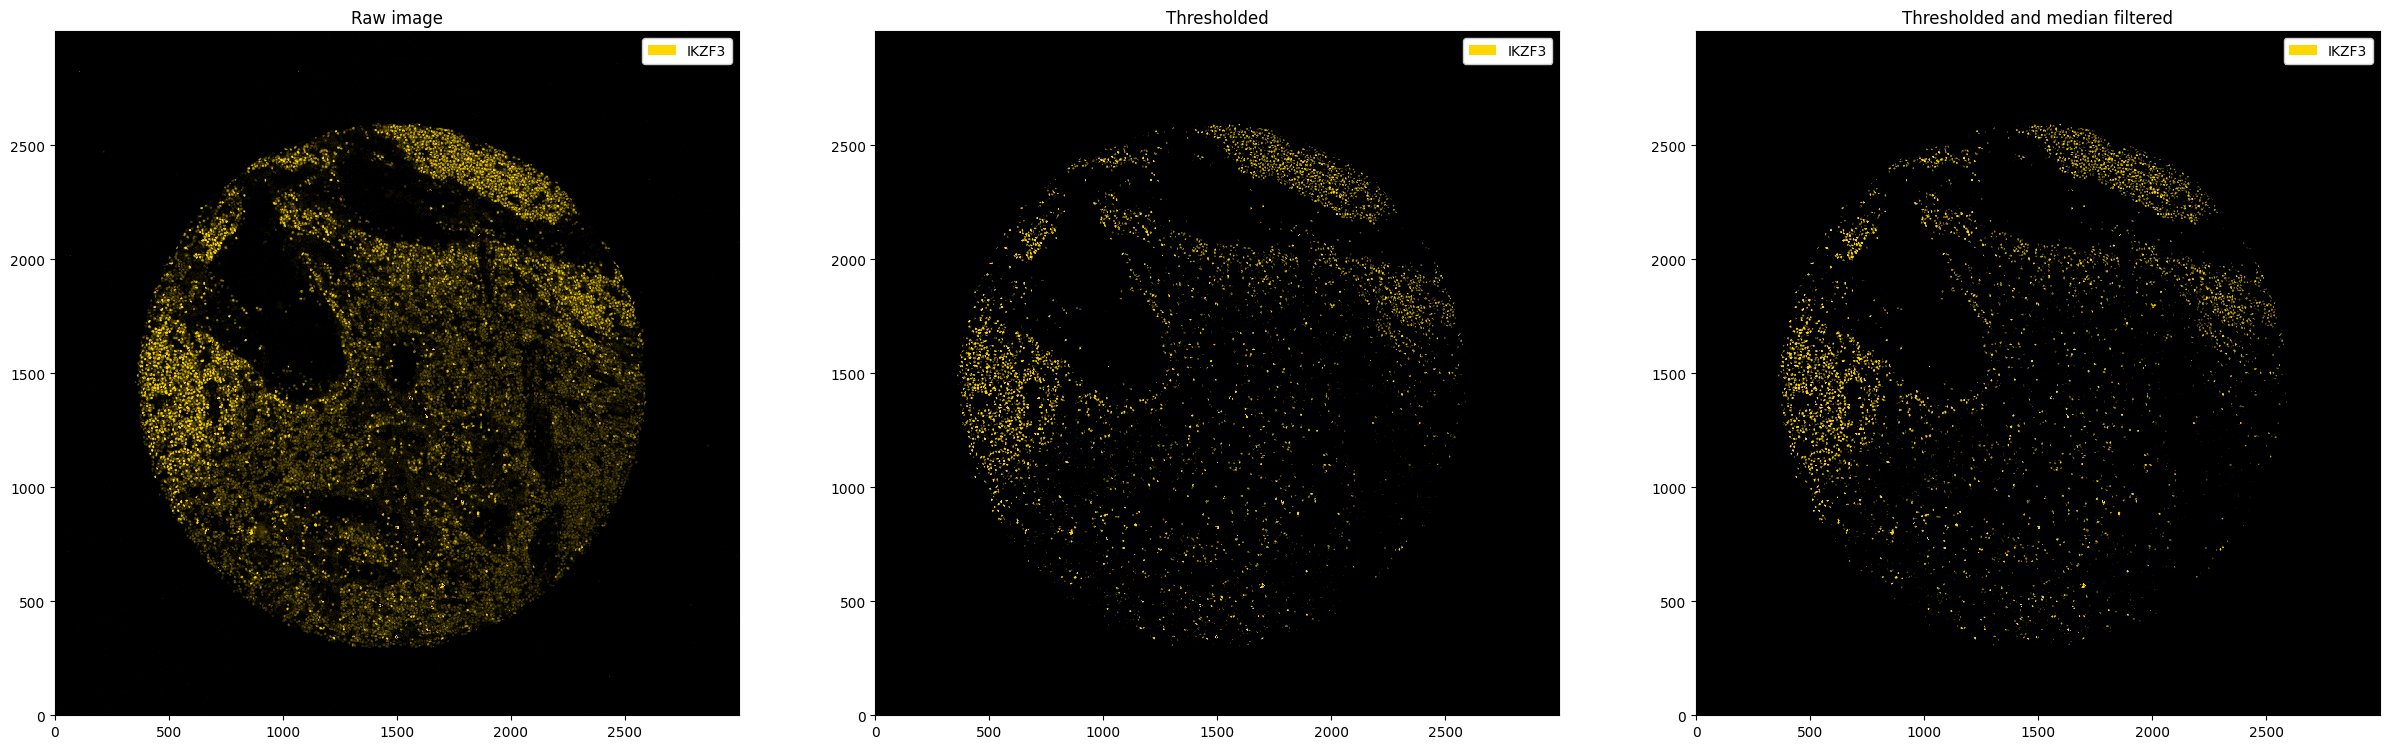

In [8]:
from scipy.signal import medfilt2d

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
_ = ds_single_channel.pl.colorize("gold").pl.show(ax=ax[0])
_ = ds_single_channel.pp.threshold(quantile=0.95).pl.colorize("gold").pl.show(ax=ax[1])
_ = (
    ds_single_channel.pp.threshold(quantile=0.95)
    .pp.apply(medfilt2d, kernel_size=3)
    .pl.colorize("gold")
    .pl.show(ax=ax[2])
)

ax[0].set_title("Raw image")
ax[1].set_title("Thresholded")
ax[2].set_title("Thresholded and median filtered")

With the `pp.apply()` method, you can provide existing (e. g. from `scipy` or `skimage`) or custom functions to your multichannel images.

Text(0.5, 1.0, 'Gaussian filter')

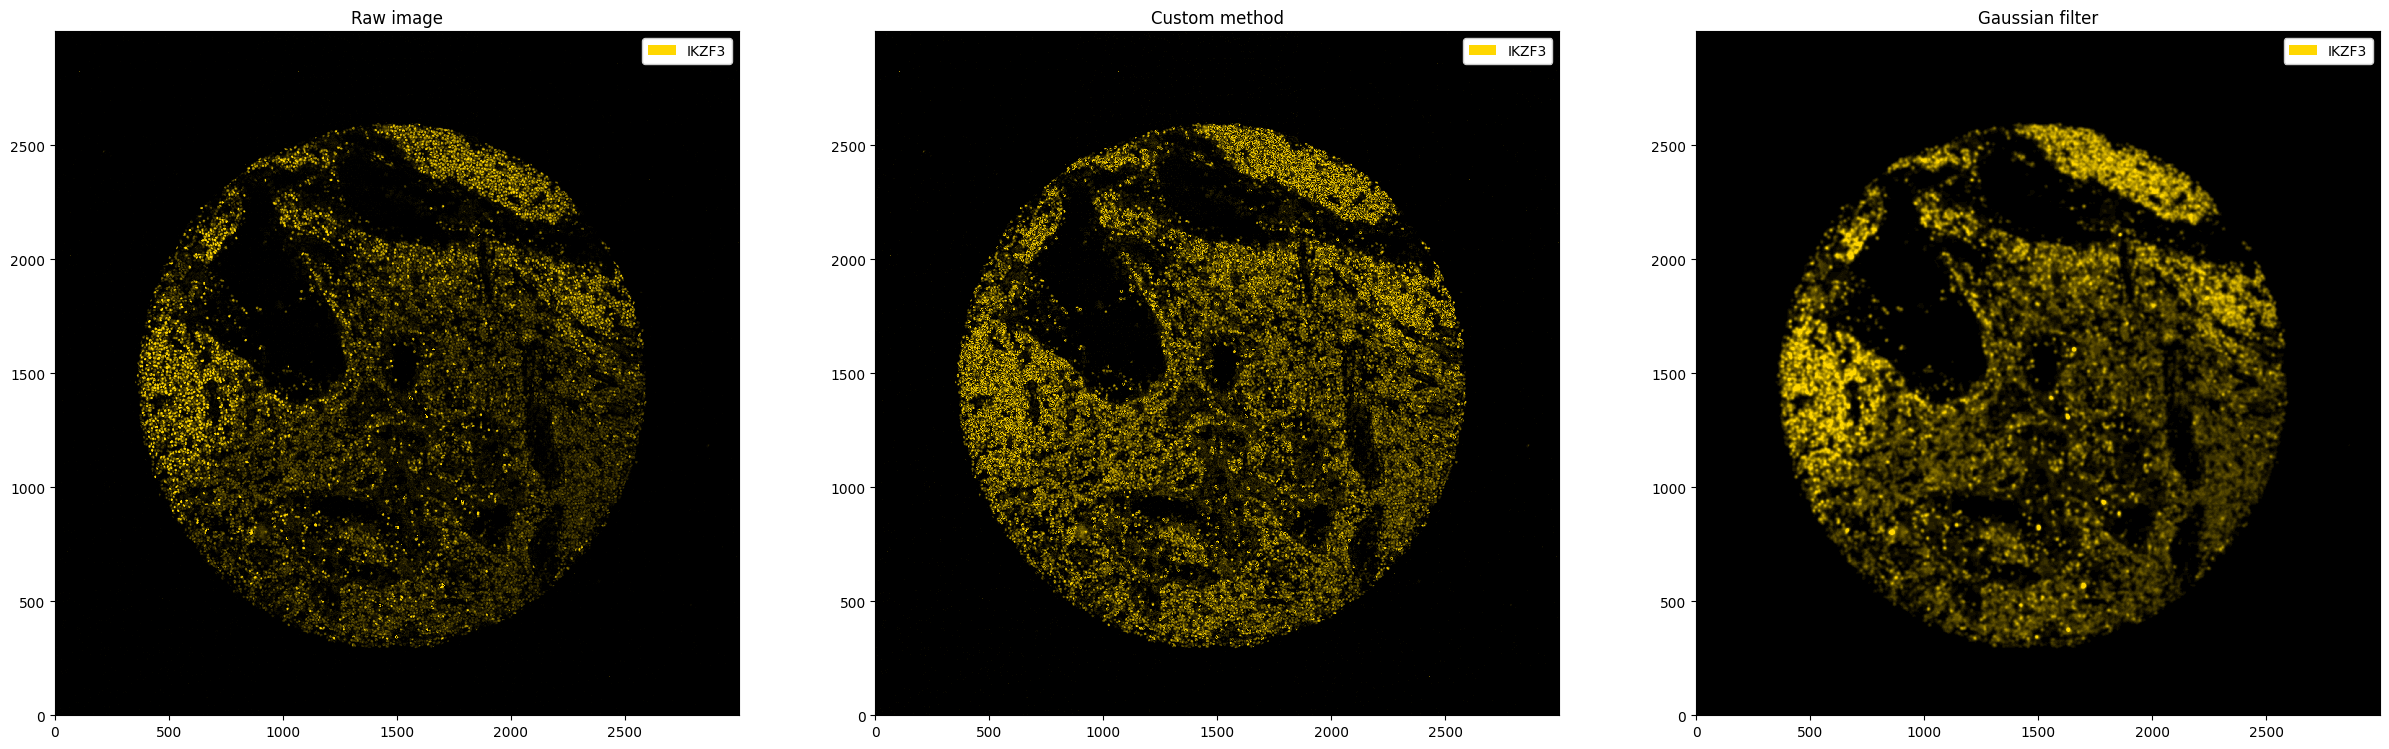

In [9]:
# application to a single channel
from scipy.ndimage import gaussian_filter


def multiply_array(arr, factor=10):
    return (arr * factor).clip(0, 255).astype("uint8")


fig, ax = plt.subplots(1, 3, figsize=(30, 10))
_ = ds_single_channel.pl.colorize("gold").pl.show(ax=ax[0])
_ = ds_single_channel.pp.apply(func=multiply_array).pl.colorize("gold").pl.show(ax=ax[1])
_ = ds_single_channel.pp.apply(func=gaussian_filter, sigma=5).pl.colorize("gold").pl.show(ax=ax[2])

ax[0].set_title("Raw image")
ax[1].set_title("Custom method")
ax[2].set_title("Gaussian filter")

Text(0.5, 1.0, 'Gaussian filter')

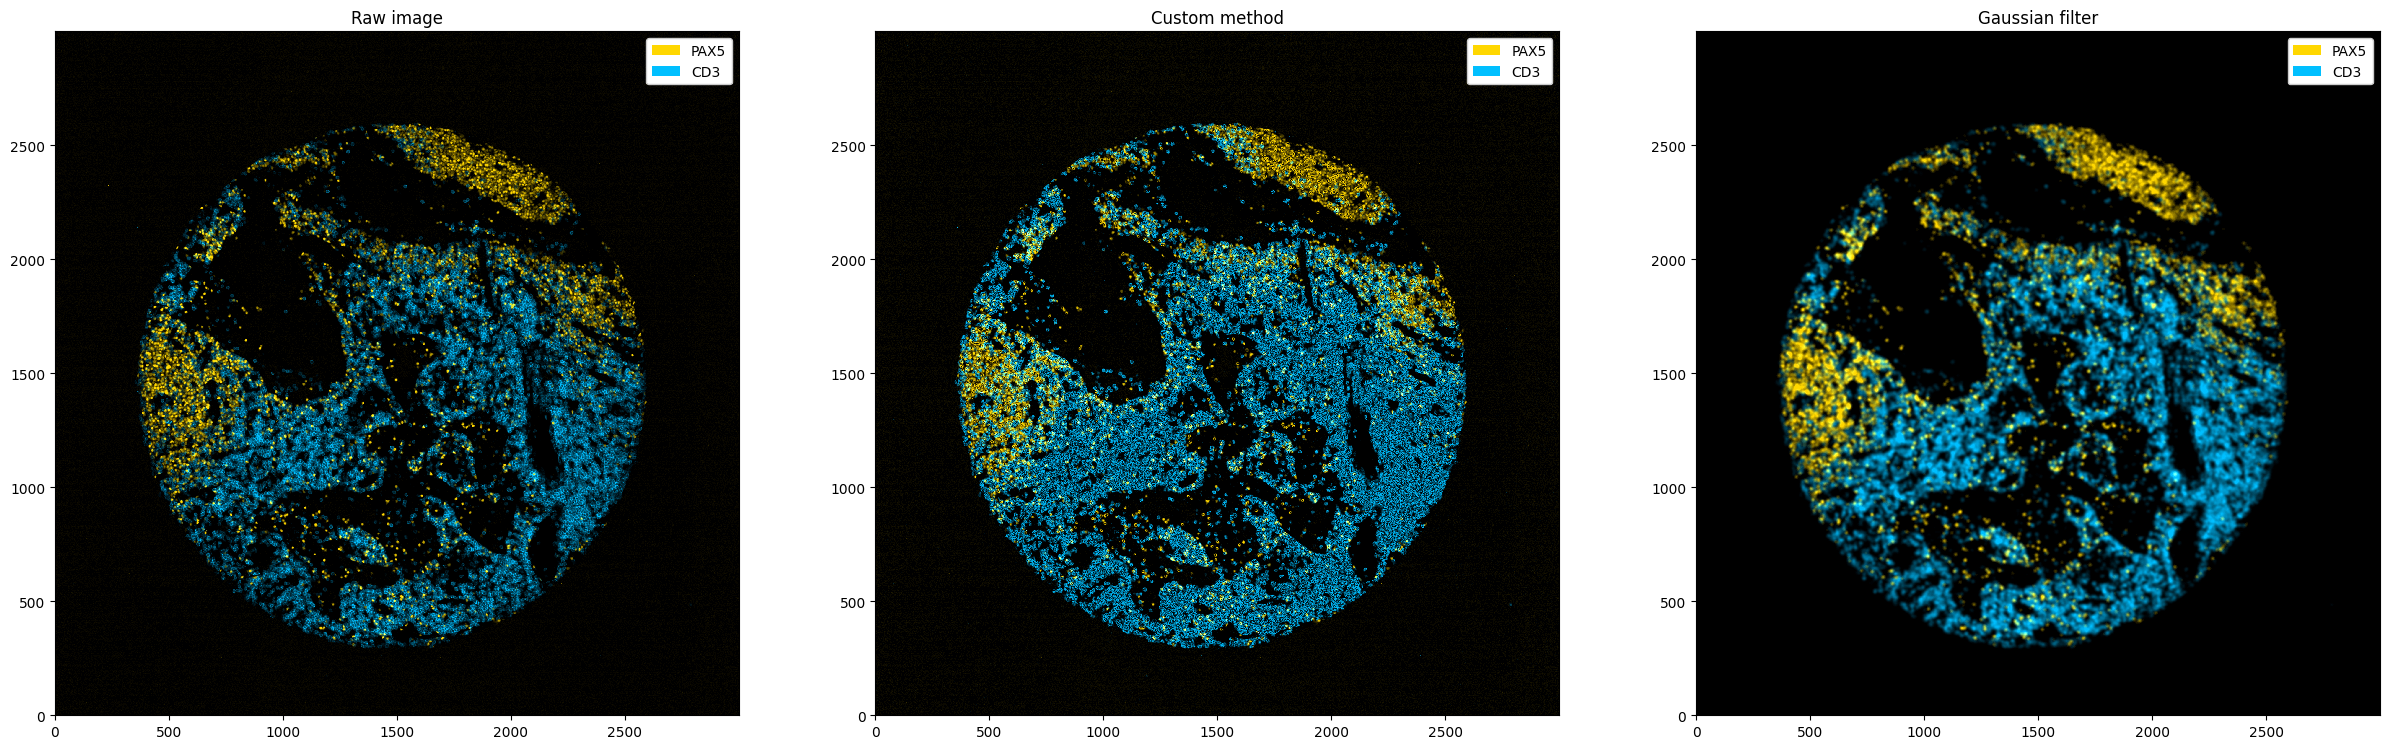

In [10]:
# application to multiple channels
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
_ = ds_multichannel.pl.colorize(["gold", "deepskyblue"]).pl.show(ax=ax[0])
_ = ds_multichannel.pp.apply(func=multiply_array).pl.colorize(["gold", "deepskyblue"]).pl.show(ax=ax[1])
_ = ds_multichannel.pp.apply(func=gaussian_filter, sigma=5).pl.colorize(["gold", "deepskyblue"]).pl.show(ax=ax[2])

ax[0].set_title("Raw image")
ax[1].set_title("Custom method")
ax[2].set_title("Gaussian filter")

Text(0.5, 1.0, 'Total variation filter')

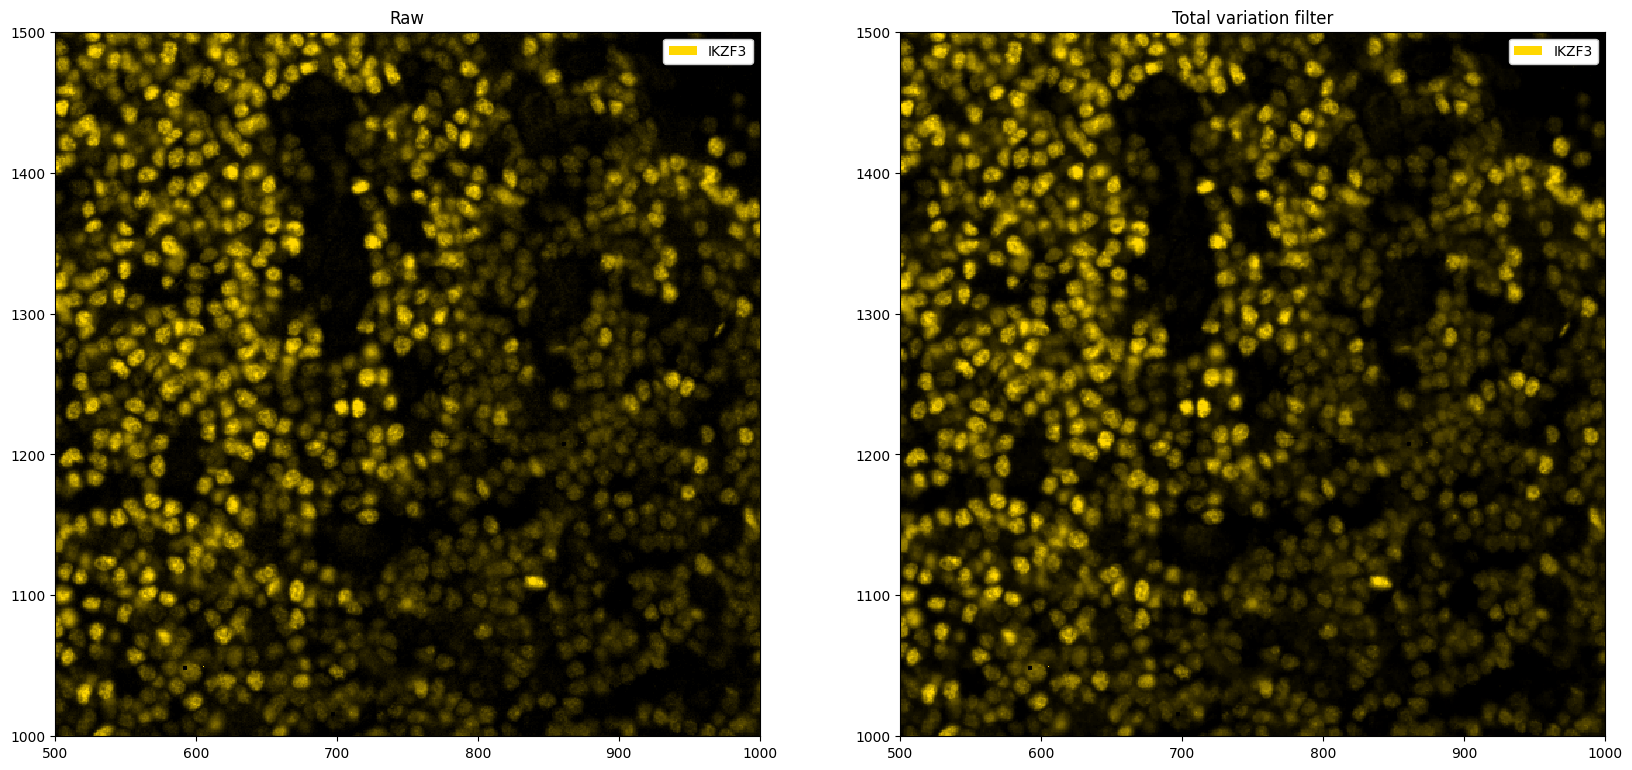

In [11]:
# total variation filter. The idea is that areas with large gradients are smoothed out, as this implies rapid fluctuation of pixel intensity values (noise).
from skimage.restoration import denoise_tv_chambolle

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# zooming in for a better view
_ = ds_single_channel.pp[500:1000, 1000:1500].pl.colorize("gold").pl.show(ax=ax[0])
_ = (
    ds_single_channel.pp.apply(func=denoise_tv_chambolle, weight=0.001)
    .pp[500:1000, 1000:1500]
    .pl.colorize("gold")
    .pl.show(ax=ax[1])
)
ax[0].set_title("Raw")
ax[1].set_title("Total variation filter")

We can of course also combine various processing methods. Let's have a look at some more.

Text(0.5, 1.0, 'Local Thresholding')

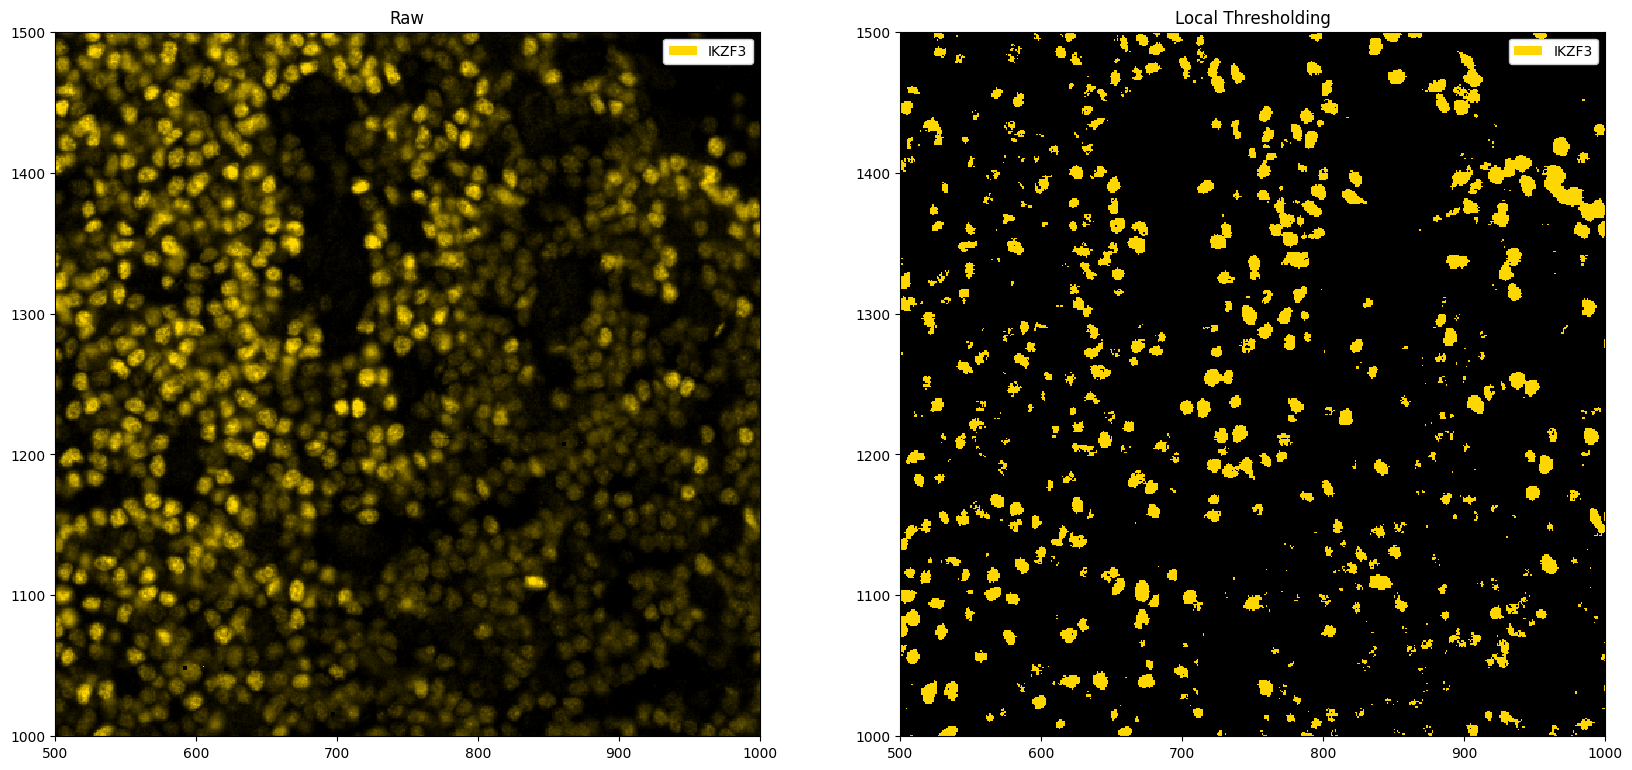

In [12]:
import skimage
import numpy as np

# example for local thresholding
def local_threshold_single_channel(im, threshold=2.5):
    selem = skimage.morphology.disk(100)
    # mean filter
    im_mean = skimage.filters.rank.mean(im, footprint=selem)
    # threshold based on mean filter
    out = np.array(im > threshold * im_mean, dtype=np.uint8)
    return out


fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# zooming in for a better view
_ = ds_single_channel.pp[500:1000, 1000:1500].pl.colorize("gold").pl.show(ax=ax[0])
_ = (
    ds_single_channel.pp.apply(func=local_threshold_single_channel)
    .pp[500:1000, 1000:1500]
    .pl.colorize("gold")
    .pl.show(ax=ax[1])
)
ax[0].set_title("Raw")
ax[1].set_title("Local Thresholding")

We can also try to automatically find a good threshold. This follows the approach demonstrated [here](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/lessons/lesson_05/basic_filtering_and_thresholding.html#Thresholding), where we look for the highest rate of change.

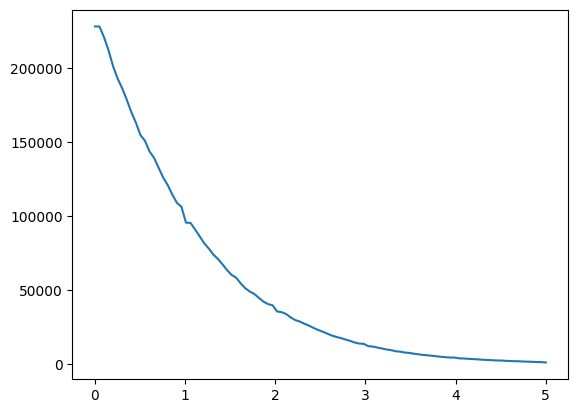

Optimal threshold: 0.8585858585858586


In [13]:
def find_optimal_threshold(im, min_k=0, max_k=5, step=100):
    selem = skimage.morphology.disk(100)
    arr = im[0, :, :]
    # mean filter
    arr_mean = skimage.filters.rank.mean(arr, footprint=selem)
    k = np.linspace(min_k, max_k, step)
    n_pix = np.empty_like(k)
    for i in range(len(k)):
        n_pix[i] = (arr > k[i] * arr_mean).sum()
    plt.plot(k, n_pix)
    plt.show()

    # Compute rough second derivative
    dn_pix_dk2 = np.diff(np.diff(n_pix))
    # Find index of maximal second derivative
    max_ind = np.argmax(dn_pix_dk2)
    # Use this index to set k
    k_opt = k[max_ind - 2]
    return k_opt


k_opt = find_optimal_threshold(ds_single_channel.pp[500:1000, 1000:1500]["_image"])
print(f"Optimal threshold: {k_opt}")

Text(0.5, 1.0, 'Local Thresholding')

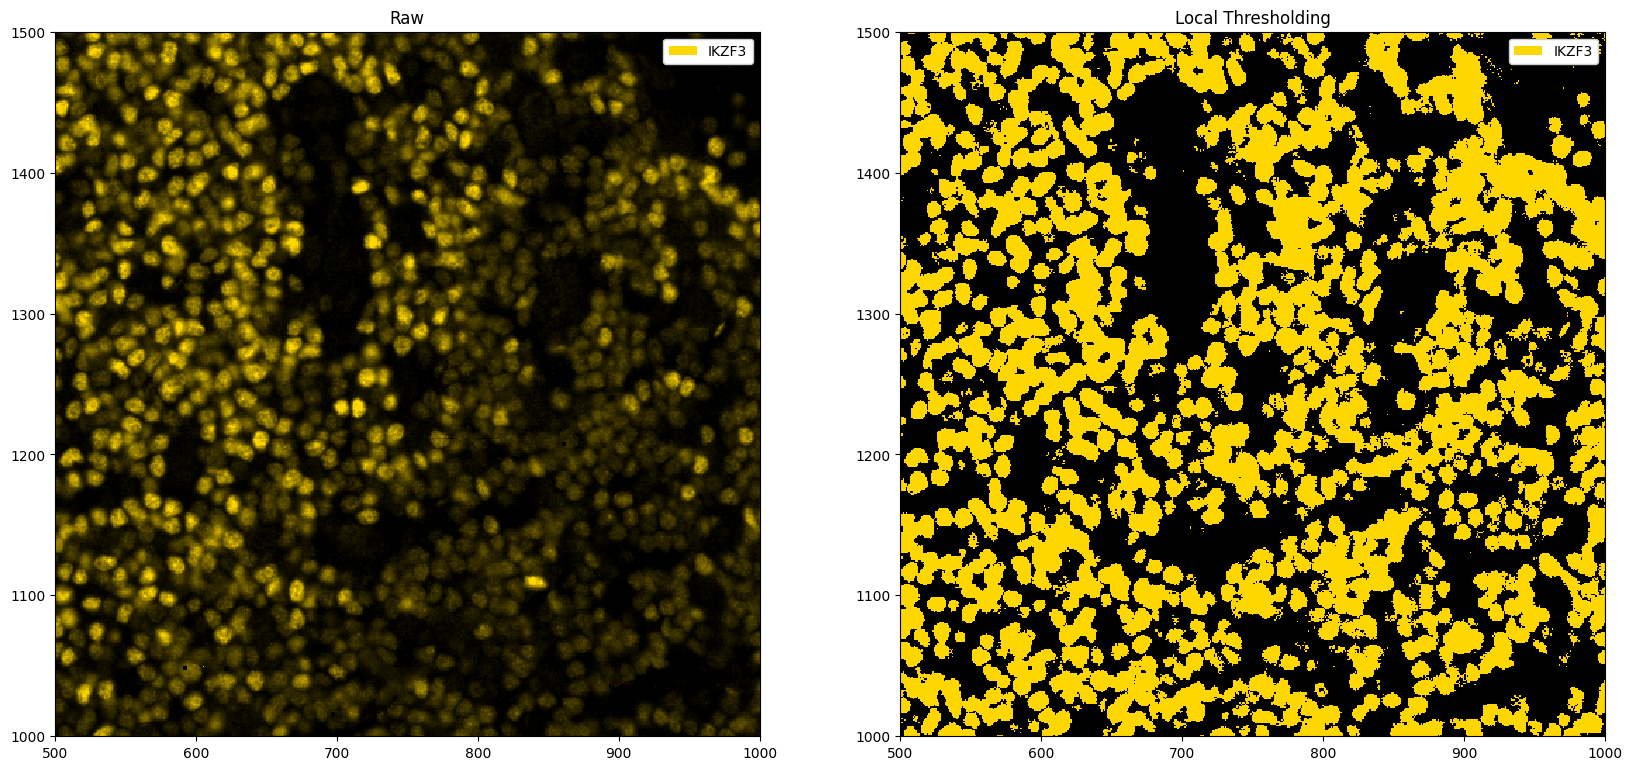

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
_ = ds_single_channel.pp[500:1000, 1000:1500].pl.colorize("gold").pl.show(ax=ax[0])
_ = (
    ds_single_channel.pp.apply(func=local_threshold_single_channel, threshold=k_opt)
    .pp[500:1000, 1000:1500]
    .pl.colorize("gold")
    .pl.show(ax=ax[1])
)
ax[0].set_title("Raw")
ax[1].set_title("Local Thresholding")

In this particular instance, the automated finding of a cutoff does not correspond to the best one, and manually looking at the parameters appears more promising. However, the example above illustrates one way to automate thresholding, which may work in certain situations.